In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, BoundaryNorm
from scipy.stats import norm, moment
from scipy.optimize import minimize

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-02-14 14:36:40.255922: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-02-14 14:36:40.255962: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)


In [2]:
plt.rcParams["figure.figsize"] = (5, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [3]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
cosmology = fiducial.AbacusSummitBase()
z = 0.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Average density

In [4]:
abacus_halos = catalog_data.Data.load('/feynman/work/dphp/mp270220/data/AbacusSummit_2Gpc_z{:.3f}.npy'.format(z))
nbar = abacus_halos.size/(boxsize**3)

## Gaussian model

In [5]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=1, nbar=nbar, damping=False)

/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/code/cosmoprimo/main/lib/python3.10/site-packages/cosmoprimo/interpolator.py:359: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


## 1D PDF

In [6]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

/tmp/ipykernel_4140089/1052069714.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\sigma$')


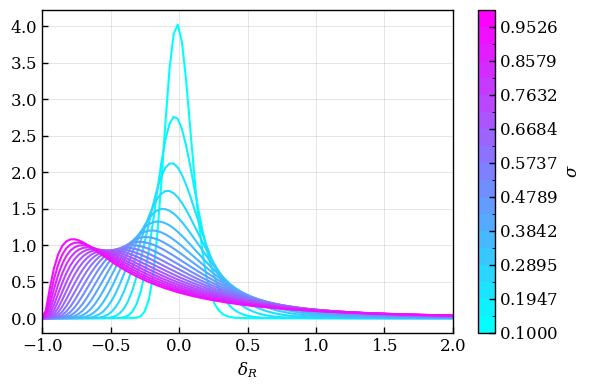

In [7]:
delta = np.linspace(-2, 4, 200)
sigmas = np.linspace(0.1, 1., 20)
delta0 = 1.
cmap = plt.cm.cool

plt.rcParams["figure.figsize"] = (6, 4)

for i in range(len(sigmas)):
    plt.plot(delta, friedrich_lognormal_model(delta, sigmas[i], 1), color=cmap(i/len(sigmas)), ls='-')
plt.xlabel(r'$\delta_R$')
plt.xlim((-delta0, 2))
fig = plt.gcf()
norm = BoundaryNorm(sigmas, cmap.N)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\sigma$')
plt.show()

/tmp/ipykernel_4140089/1942848607.py:10: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_0$')


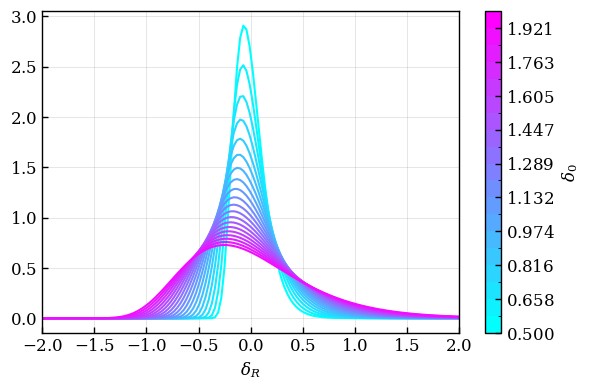

In [8]:
delta0s = np.linspace(0.5, 2, 20)
sigma = 0.3

for i in range(len(delta0s)):
    plt.plot(delta, friedrich_lognormal_model(delta, sigma, delta0s[i]), color=cmap(i/len(delta0s)), ls='-')
plt.xlabel(r'$\delta_R$')
plt.xlim((-2., 2))
fig = plt.gcf()
norm = BoundaryNorm(delta0s, cmap.N)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_0$')
plt.show()

## Density splits

In [9]:
nsplits = 3
th_bins = np.array([-np.inf, -0.2,  0.1, np.inf])

In [10]:
def compute_main_term(delta, sigma, delta0=1., delta0_R=1., bias=1., xi_R=None, shotnoise=None):
    if xi_R is None:
        xi_R = model.xi_R * bias**2
        if shotnoise is not None:
            xi_R = (model.xi_R + shotnoise) * bias**2
    if math.isfinite(delta):
        a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
        b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

def compute_dsplits(sigma, delta0=1., delta0_R=1., th_bins=th_bins, bias=1., xi_R=None, shotnoise=None):
    dsplits = list()

    for i in range(len(th_bins)-1):
        d1 = max(th_bins[i], -delta0_R)
        d2 = th_bins[i+1]
        a1, b1 = compute_main_term(d1, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        a2, b2 = compute_main_term(d2, sigma, delta0=delta0, delta0_R=delta0_R, bias=bias, xi_R=xi_R, shotnoise=shotnoise)
        main_term = (a2 - a1) / (b2 - b1)
        dsplits.append(delta0*(main_term - 1))

    return dsplits

/tmp/ipykernel_4140089/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_4140089/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))
/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


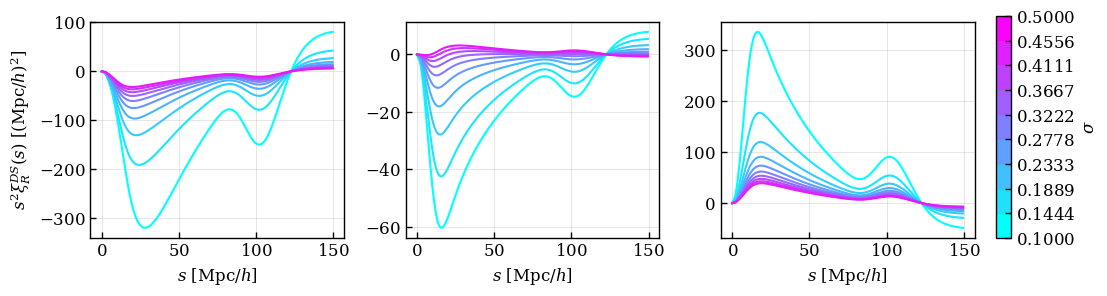

In [11]:
sigmas = np.linspace(0.1, 0.5, 10)
delta0 = 1.

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for i in range(len(sigmas)):
    dsplits = compute_dsplits(sigma=sigmas[i], delta0=1., delta0_R=delta0, bias=1., xi_R=None)

    for ds in range(nsplits):
        axes[ds].plot(model.sep, model.sep**2 * dsplits[ds], color=cmap(i/len(sigmas)))
        axes[ds].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(sigmas, cmap.N)
cbar_ax = fig.add_axes([1.001, 0.21, 0.015, 0.74])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label=r'$\sigma$')
plt.show()

/tmp/ipykernel_4140089/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_4140089/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


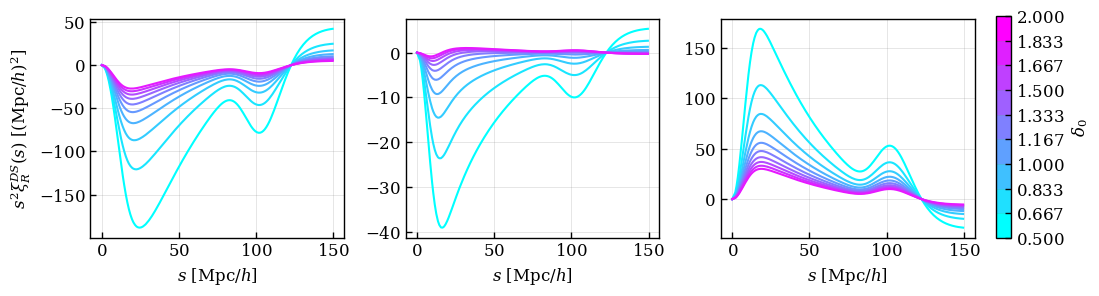

In [12]:
sigma = 0.3
delta0s = np.linspace(0.5, 2, 10)

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for i in range(len(delta0s)):
    dsplits = compute_dsplits(sigma=sigma, delta0=1., delta0_R=delta0s[i], bias=1., xi_R=None)

    for ds in range(nsplits):
        axes[ds].plot(model.sep, model.sep**2 * dsplits[ds], color=cmap(i/len(sigmas)))
        axes[ds].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(delta0s, cmap.N)
cbar_ax = fig.add_axes([1.001, 0.21, 0.015, 0.74])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label=r'$\delta_0$')
plt.show()

/tmp/ipykernel_4140089/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_4140089/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


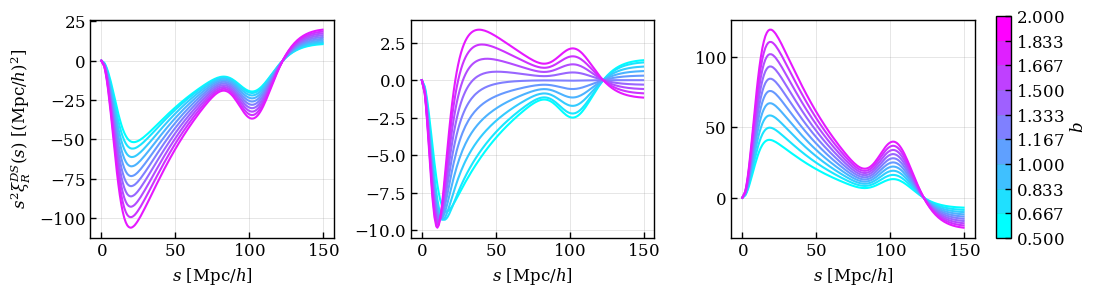

In [13]:
sigma = 0.3
bias = np.linspace(0.5, 2, 10)

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for i in range(len(bias)):
    dsplits = compute_dsplits(sigma=sigma, delta0=bias[i], delta0_R=bias[i], bias=bias[i], xi_R=None)

    for ds in range(nsplits):
        axes[ds].plot(model.sep, model.sep**2 * dsplits[ds], color=cmap(i/len(sigmas)))
        axes[ds].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(delta0s, cmap.N)
cbar_ax = fig.add_axes([1.001, 0.21, 0.015, 0.74])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label=r'$b$')
plt.show()

/tmp/ipykernel_4140089/1906400520.py:7: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2. - np.log(1 + xi_R/(delta0*delta0_R))) / (np.sqrt(2) * sigma))
/tmp/ipykernel_4140089/1906400520.py:8: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log(1 + delta/delta0_R) + sigma**2/2.) / (np.sqrt(2) * sigma))


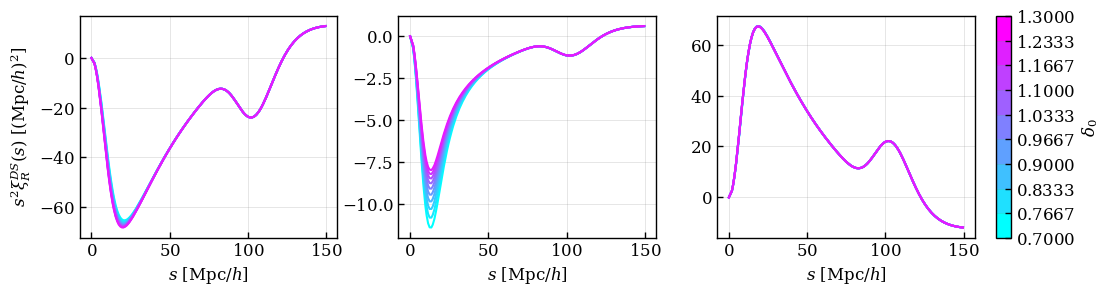

In [21]:
sigma = 0.3
delta0s = np.linspace(0.7, 1.3, 10)

fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharey=False)

for i in range(len(delta0s)):
    dsplits = compute_dsplits(sigma=sigma, delta0=delta0s[i], delta0_R=1, bias=1., xi_R=None)

    for ds in range(nsplits):
        axes[ds].plot(model.sep, model.sep**2 * dsplits[ds], color=cmap(i/len(sigmas)))
        axes[ds].set_xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

axes[0].set_ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(delta0s, cmap.N)
cbar_ax = fig.add_axes([1.001, 0.21, 0.015, 0.74])
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax, label=r'$\delta_0$')
plt.show()

/tmp/ipykernel_4140089/1906400520.py:26: RuntimeWarning: invalid value encountered in divide
  main_term = (a2 - a1) / (b2 - b1)
/tmp/ipykernel_4140089/474501214.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_2$')


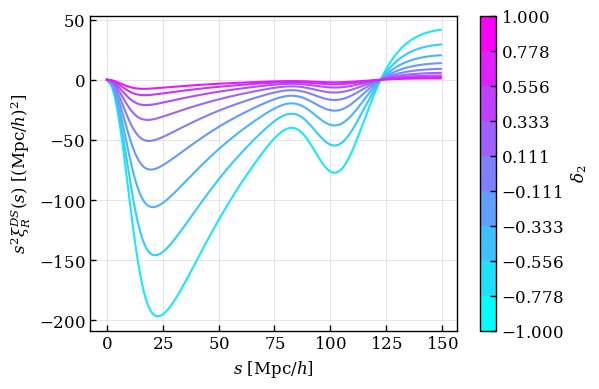

In [14]:
sigma = 0.3
bias = 1.5
delta0 = 1.5
th = np.linspace(-1, 1, 10)

for i in range(len(th)):
    th_bins = np.array([-1, th[i]])
    dsplits = compute_dsplits(sigma=sigma, delta0=bias, delta0_R=delta0, bias=bias, th_bins=th_bins, xi_R=None)

    plt.plot(model.sep, model.sep**2 * dsplits[0], color=cmap(i/len(th)))
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(th, cmap.N)
fig = plt.gcf()
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_2$')
plt.show()

/tmp/ipykernel_4140089/1747720895.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_1$')


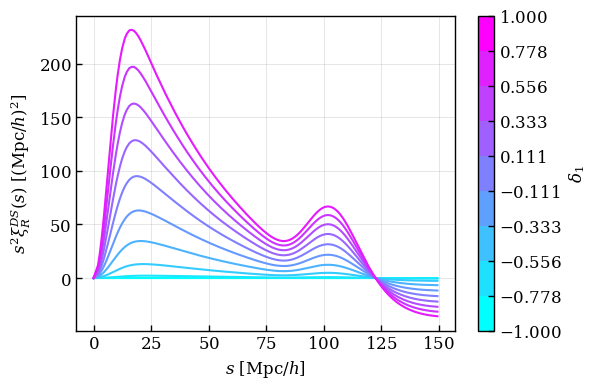

In [15]:
sigma = 0.3
bias = 1.5
delta0 = 1.5
th = np.linspace(-1, 1, 10)

for i in range(len(th)):
    th_bins = np.array([th[i], np.inf])
    dsplits = compute_dsplits(sigma=sigma, delta0=bias, delta0_R=delta0, bias=bias, th_bins=th_bins, xi_R=None)

    plt.plot(model.sep, model.sep**2 * dsplits[0], color=cmap(i/len(th)))
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(th, cmap.N)
fig = plt.gcf()
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_1$')
plt.show()

/tmp/ipykernel_4140089/16327502.py:12: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_1$')


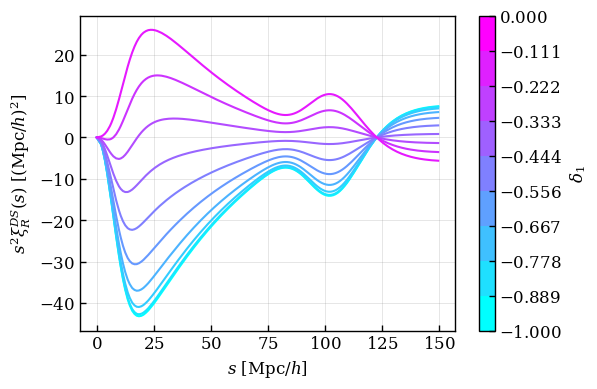

In [16]:
th = np.linspace(-1., 0, 10)

for i in range(len(th)):
    th_bins = np.array([th[i], 0.2])
    dsplits = compute_dsplits(sigma=sigma, delta0=bias, delta0_R=delta0, bias=bias, th_bins=th_bins, xi_R=None)

    plt.plot(model.sep, model.sep**2 * dsplits[0], color=cmap(i/len(sigmas)))
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
norm = BoundaryNorm(th, cmap.N)
fig = plt.gcf()
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_1$')
plt.show()

/tmp/ipykernel_4140089/2438177345.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_2$')


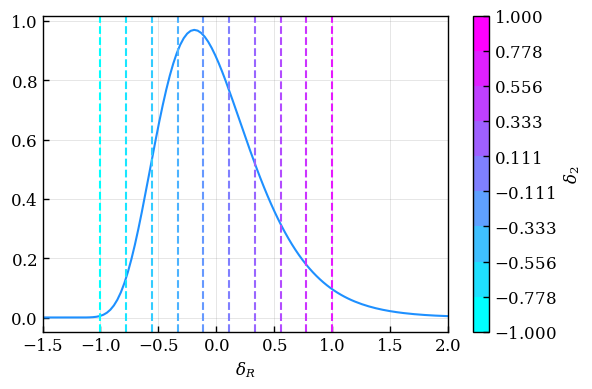

In [17]:
sigma = 0.3
bias = 1.5
delta0 = 1.5
th = np.linspace(-1., 1, 10)

plt.plot(delta, friedrich_lognormal_model(delta, sigma=sigma, delta0=delta0), color='C0', ls='-')
#plt.axvline(0.2, color='black')
for i in range(len(th)):
    plt.axvline(th[i], color=cmap(i/len(th)), ls='--')
plt.xlabel(r'$\delta_R$')
plt.xlim((-delta0, 2))
fig = plt.gcf()
norm = BoundaryNorm(th, cmap.N)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), label=r'$\delta_2$')
plt.show()